In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Importing other required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import seaborn as sns
import glob 
import pickle
import IPython.display as ipd  # To play sound in the notebook

# Data Preparation

In [2]:
RAV = "/kaggle/input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/"
CREMA = "/kaggle/input/speech-emotion-recognition-en/Crema/"
TESS = "/kaggle/input/speech-emotion-recognition-en/Tess/"
SAVEE = "/kaggle/input/speech-emotion-recognition-en/Savee/"

In [3]:
RAV_directory_list = os.listdir(RAV)

file_emotion = []
file_path = []
for dir in RAV_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(RAV + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(RAV + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/speech-emotion-recognition-en/Ra...
1   neutral  /kaggle/input/speech-emotion-recognition-en/Ra...
2   disgust  /kaggle/input/speech-emotion-recognition-en/Ra...
3   disgust  /kaggle/input/speech-emotion-recognition-en/Ra...
4   neutral  /kaggle/input/speech-emotion-recognition-en/Ra...

In [4]:
CREMA_dirlist = os.listdir(CREMA)

file_emotion = []
file_path = []

for file in CREMA_dirlist:
    # storing file paths
    file_path.append(CREMA + file)
    # storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    else:
        file_emotion.append('unknown')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /kaggle/input/speech-emotion-recognition-en/Cr...
1    happy  /kaggle/input/speech-emotion-recognition-en/Cr...
2    happy  /kaggle/input/speech-emotion-recognition-en/Cr...
3  disgust  /kaggle/input/speech-emotion-recognition-en/Cr...
4  disgust  /kaggle/input/speech-emotion-recognition-en/Cr...

In [5]:
TESS_dirlist = os.listdir(TESS)

file_emotion = []
file_path = []

for dir in TESS_dirlist:
    filename = os.listdir(TESS + dir)   
    for file in filename:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(TESS + dir + "/" + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  /kaggle/input/speech-emotion-recognition-en/Te...
1     fear  /kaggle/input/speech-emotion-recognition-en/Te...
2     fear  /kaggle/input/speech-emotion-recognition-en/Te...
3     fear  /kaggle/input/speech-emotion-recognition-en/Te...
4     fear  /kaggle/input/speech-emotion-recognition-en/Te...

In [6]:
SAVEE_dirlist = os.listdir(SAVEE)

file_emotion = []
file_path = []

for file in SAVEE_dirlist:
    file_path.append(SAVEE + file)
    part = file.split('_')[1]
    patition = part[:-6]
    if patition=='a':
        file_emotion.append('angry')
    elif patition=='d':
        file_emotion.append('disgust')
    elif patition=='f':
        file_emotion.append('fear')
    elif patition=='h':
        file_emotion.append('happy')
    elif patition=='n':
        file_emotion.append('neutral')
    elif patition=='sa':
        file_emotion.append('sad')
    elif patition=='su':
        file_emotion.append('surprise')
    else:
        file_emotion.append('unknown') 
    
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    happy  /kaggle/input/speech-emotion-recognition-en/Sa...
1     fear  /kaggle/input/speech-emotion-recognition-en/Sa...
2    happy  /kaggle/input/speech-emotion-recognition-en/Sa...
3  disgust  /kaggle/input/speech-emotion-recognition-en/Sa...
4    angry  /kaggle/input/speech-emotion-recognition-en/Sa...

In [7]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/speech-emotion-recognition-en/Ra...
1   neutral  /kaggle/input/speech-emotion-recognition-en/Ra...
2   disgust  /kaggle/input/speech-emotion-recognition-en/Ra...
3   disgust  /kaggle/input/speech-emotion-recognition-en/Ra...
4   neutral  /kaggle/input/speech-emotion-recognition-en/Ra...

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


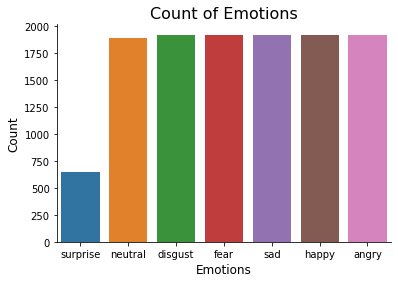

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
data_path.drop(data_path[data_path.Emotions == 'surprise'].index, inplace=True)
data_path.drop(data_path[data_path.Emotions == 'neutral'].index, inplace=True)
data_path.drop(data_path[data_path.Emotions == 'fear'].index, inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


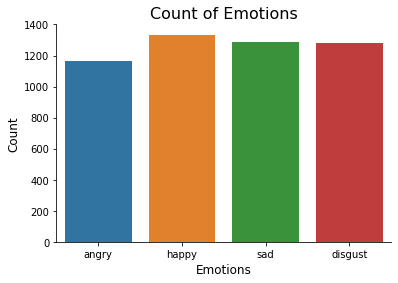

In [10]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [11]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [12]:
# to play the audio files
from IPython.display import Audio

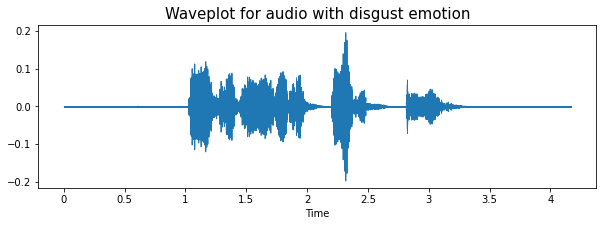

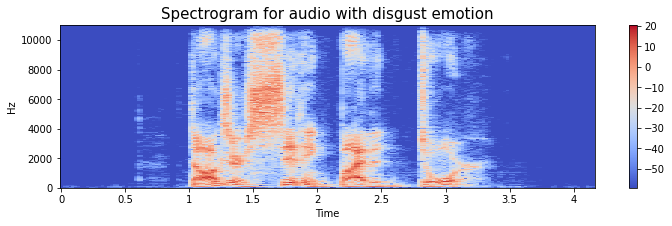

In [13]:
emotion='disgust'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

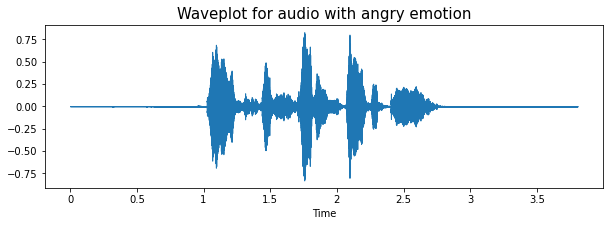

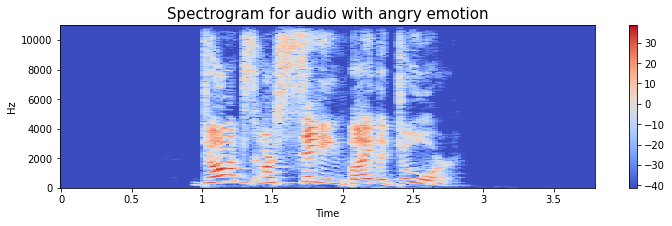

In [14]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

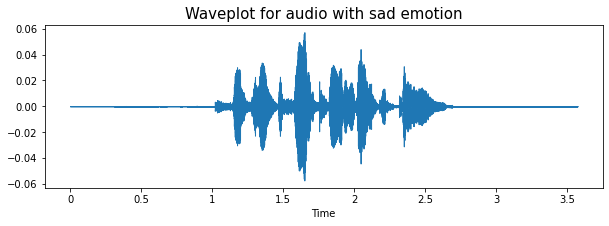

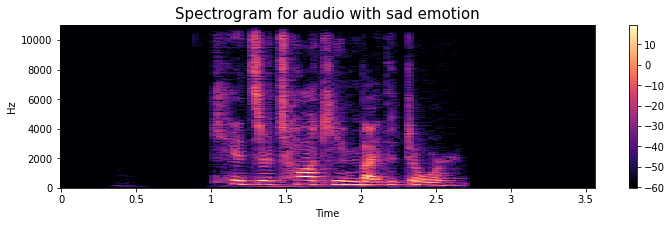

In [15]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

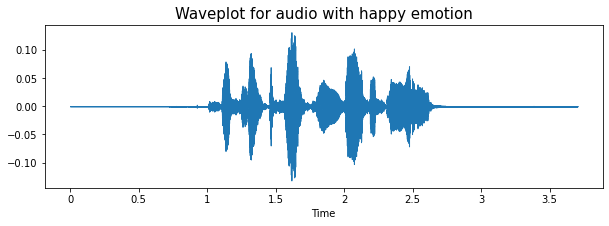

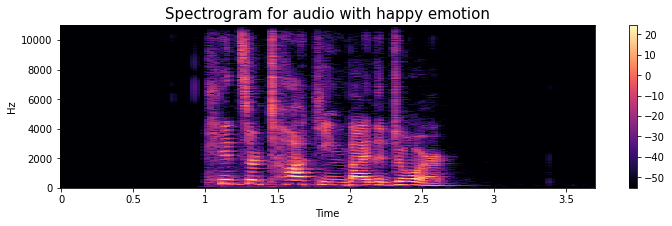

In [16]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

In [17]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = data_path[data_path["Emotions"] == "happy"]["Path"].iloc[0]
data, sample_rate = librosa.load(path)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports until


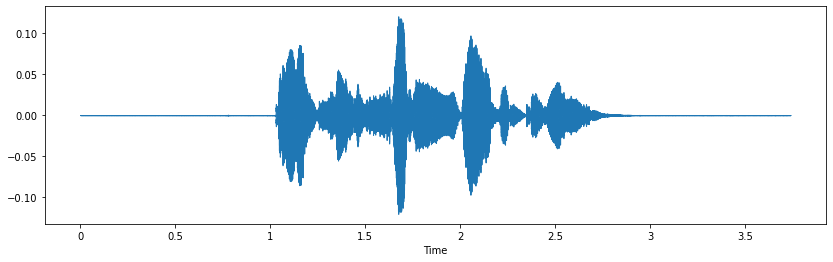

In [18]:
# contoh audio
plt.figure(figsize=(14,4))
librosa.display.waveshow(data, sampling_rate)
Audio(path)

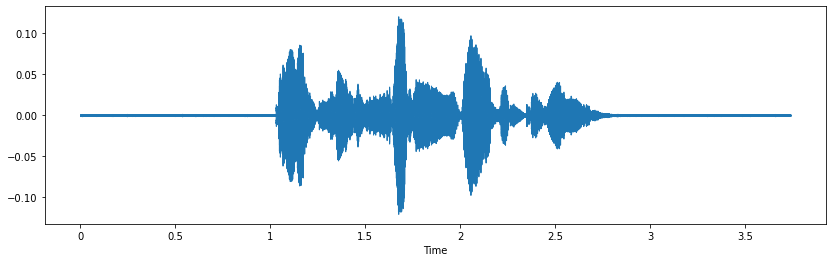

In [19]:
# data noised
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Pass rate=0.5 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  if sys.path[0] == "":


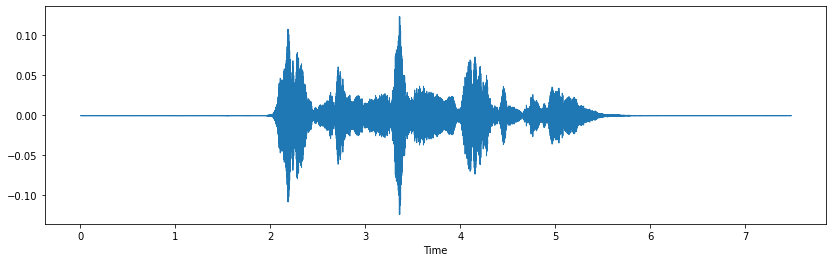

In [20]:
#data stretched
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)

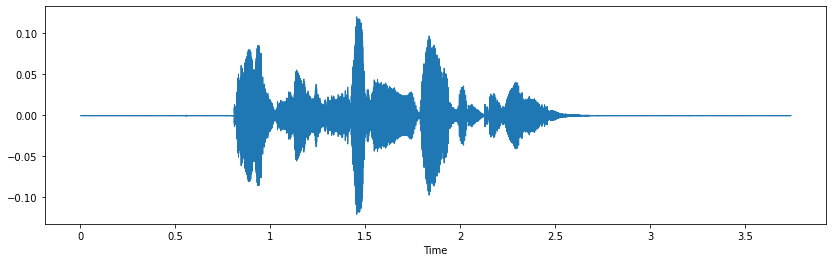

In [21]:
#data shifted
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Pass sr=22050, n_steps=0.06366852426877745 as keyword args. From version 0.10 passing these as positional arguments will result in an error


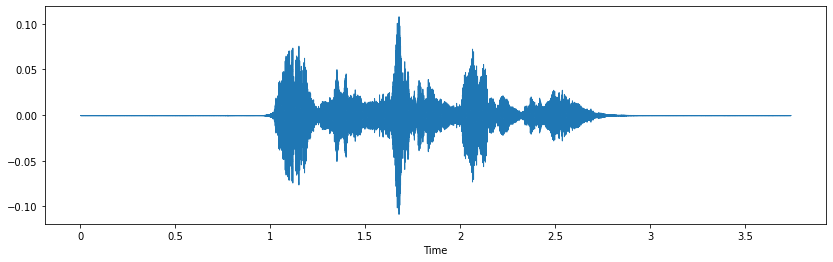

In [22]:
#data pitched
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

In [23]:
n_fft = 2048
hop_length = 512

In [24]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


# def spc_entropy(data, sr):
#     spc_en = spectral_entropy(data, sf=sr, method="fft")
#     return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [25]:
path = np.array(data_path["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

35329

In [26]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
# print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (70,)
Energy:  (70,)
Entropy of Energy : (70,)
RMS : (70,)
Spectral Centroid : (70,)
Spectral Flux:  ()
Spectral Rollof:  (70,)
Chroma STFT:  (840,)
MelSpectrogram:  (8960,)
MFCC:  (1400,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


In [27]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [28]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [29]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [30]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(data_path.Path, data_path.Emotions, range(data_path.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 sampl

In [31]:
features_path = "./features.csv"

In [32]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

0         1         2         3         4         5         6  \
0  0.119141  0.181641  0.252930  0.256836  0.257324  0.278320  0.268066   
1  0.246582  0.380371  0.496094  0.495605  0.497070  0.488770  0.500000   
2  0.108887  0.164551  0.232422  0.228027  0.247070  0.246094  0.217285   
3  0.238770  0.359375  0.479492  0.485840  0.494629  0.502930  0.508789   
4  0.234863  0.364746  0.473633  0.434570  0.439941  0.398438  0.390625   

          7         8         9  ...      2367      2368      2369      2370  \
0  0.304199  0.274902  0.290527  ...  1.746208  1.411248  1.125566  0.745315   
1  0.499512  0.508789  0.493164  ...  0.703232 -2.940759  1.790971  3.253469   
2  0.185547  0.128906  0.102051  ...  1.796041  0.921023  0.089623 -0.694563   
3  0.503418  0.498535  0.498535  ...  2.257362  2.086537 -1.508945 -3.999369   
4  0.409668  0.420410  0.467285  ...  0.000000  0.000000  0.000000  0.000000   

       2371      2372      2373      2374      2375  labels  
0  0.286653 -0.138735 -0.465458 -0.763582 -1.192943   angry  
1 -1.283561 -1.947765  5.127835  2.505290  3.911157   angry  
2 -1.428298 -2.106982 -2.723543 -3.267769 -3.726738   angry  
3  2.135702 -1.926687 -1.047203  1.333706  2.668870   angry  
4  0.000000  0.000000  0.000000  0.000000  0.000000   happy  

[5 rows x 2377 columns]

In [33]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(20292, 2377)


In [34]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(20292, 2377)

In [35]:
extracted_df.head()

0         1         2         3         4         5         6  \
0  0.119141  0.181641  0.252930  0.256836  0.257324  0.278320  0.268066   
1  0.246582  0.380371  0.496094  0.495605  0.497070  0.488770  0.500000   
2  0.108887  0.164551  0.232422  0.228027  0.247070  0.246094  0.217285   
3  0.238770  0.359375  0.479492  0.485840  0.494629  0.502930  0.508789   
4  0.234863  0.364746  0.473633  0.434570  0.439941  0.398438  0.390625   

          7         8         9  ...      2367      2368      2369      2370  \
0  0.304199  0.274902  0.290527  ...  1.746208  1.411248  1.125566  0.745315   
1  0.499512  0.508789  0.493164  ...  0.703232 -2.940759  1.790971  3.253469   
2  0.185547  0.128906  0.102051  ...  1.796041  0.921023  0.089623 -0.694563   
3  0.503418  0.498535  0.498535  ...  2.257362  2.086537 -1.508945 -3.999369   
4  0.409668  0.420410  0.467285  ...  0.000000  0.000000  0.000000  0.000000   

       2371      2372      2373      2374      2375  labels  
0  0.286653 -0.138735 -0.465458 -0.763582 -1.192943   angry  
1 -1.283561 -1.947765  5.127835  2.505290  3.911157   angry  
2 -1.428298 -2.106982 -2.723543 -3.267769 -3.726738   angry  
3  2.135702 -1.926687 -1.047203  1.333706  2.668870   angry  
4  0.000000  0.000000  0.000000  0.000000  0.000000   happy  

[5 rows x 2377 columns]

# Model Data Preparation

In [36]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [37]:
from sklearn.preprocessing import OneHotEncoder
lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'happy' 'sad']


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16233, 2376), (4059, 2376), (16233, 4), (4059, 4))

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((14609, 2376), (4059, 2376), (1624, 2376), (14609, 4), (4059, 4), (1624, 4))

In [40]:
# Standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((14609, 2376), (4059, 2376), (1624, 2376), (14609, 4), (4059, 4), (1624, 4))

In [41]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(14609, 2376, 1)

# Modelling

In [42]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

In [43]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [44]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [45]:
model = Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc", f1_m])

model.summary()

2022-05-31 11:31:44.918187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 11:31:45.036623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 11:31:45.037426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 11:31:45.038668: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1188, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 594, 256)          6

In [46]:
EPOCHS = 25
batch_size = 64

In [47]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction])

2022-05-31 11:31:57.636028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-05-31 11:32:00.542226: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


229/229 [==============================] - 48s 170ms/step - loss: 1.1983 - acc: 0.5520 - f1_m: 0.5203 - val_loss: 9.5775 - val_acc: 0.2839 - val_f1_m: 0.2873
Epoch 2/25
229/229 [==============================] - 38s 168ms/step - loss: 0.8867 - acc: 0.6355 - f1_m: 0.6079 - val_loss: 1.6155 - val_acc: 0.5209 - val_f1_m: 0.5163
Epoch 3/25
229/229 [==============================] - 38s 168ms/step - loss: 0.7797 - acc: 0.6800 - f1_m: 0.6646 - val_loss: 1.0270 - val_acc: 0.6275 - val_f1_m: 0.6103
Epoch 4/25
229/229 [==============================] - 38s 168ms/step - loss: 0.6986 - acc: 0.7205 - f1_m: 0.7064 - val_loss: 0.9512 - val_acc: 0.6515 - val_f1_m: 0.6519
Epoch 5/25
229/229 [==============================] - 38s 168ms/step - loss: 0.6153 - acc: 0.7587 - f1_m: 0.7507 - val_loss: 0.7102 - val_acc: 0.7229 - val_f1_m: 0.7132
Epoch 6/25
229/229 [==============================] - 38s 167ms/step - loss: 0.5095 - acc: 0.8040 - f1_m: 0.7963 - val_loss: 0.7347 - val_acc: 0.7069 - val_f1_m: 0.69

127/127 [==============================] - 3s 25ms/step - loss: 0.2055 - acc: 0.9554 - f1_m: 0.9561
Accuracy of our model on test data :  95.54077386856079 %


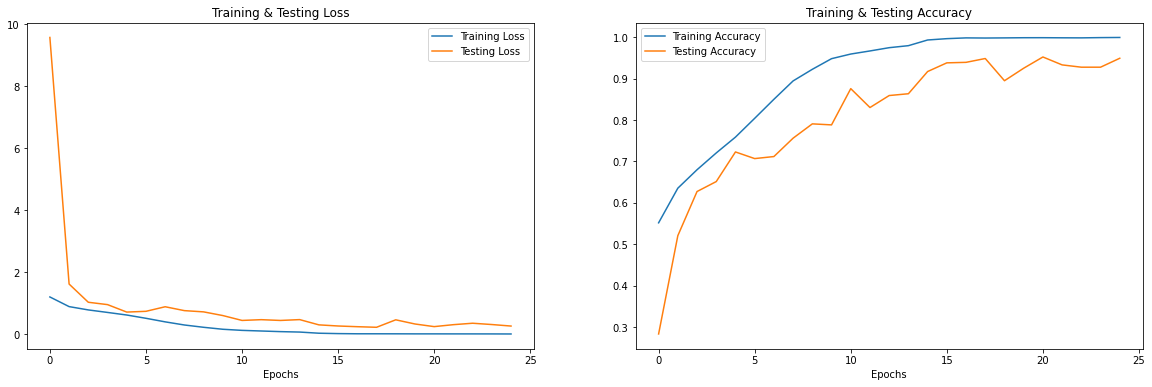

In [48]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [49]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([3, 0, 1, ..., 0, 3, 3])

In [50]:
y_check = np.argmax(y_test, axis=1)
y_check

array([3, 0, 2, ..., 0, 3, 3])

In [51]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [52]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 847   12   17    5]
 [  21  932   12   30]
 [  27   14 1075   10]
 [   4   19   10 1024]]


NameError: name 'itertools' is not defined

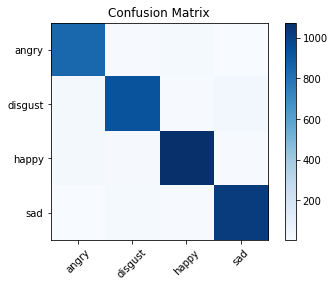

In [53]:
cm_plot_labels = ['angry', 'disgust', 'happy', 'sad']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [54]:
path_to_model = "./res_model.h5"

model.save(path_to_model)